# Importing necessary things

In [79]:
#conda install -c conda-forge fbprophet
#conda install -c conda-forge/label/cf201901 fbprophet
#pip install fbprophet
#pip install holidays==0.9.12
#pip install --upgrade plotly

#conda install nb_conda jupyter
#pip install pmdarima

#conda install -c conda-forge tensorflow 
#pip install tensorflow 
#pip install --upgrade tensorflow-gpu
#pip install Keras

In [80]:
import pickle
import bz2

import pandas as pd
from pandas import concat
import time
import warnings                                  
warnings.filterwarnings('ignore')

import numpy as np                                                            
import matplotlib.pyplot as plt                  
import seaborn as sns    
from math import sqrt

from dateutil.relativedelta import relativedelta 
from scipy.optimize import minimize              

import statsmodels.formula.api as smf            
import statsmodels.tsa.api as smt
import statsmodels.api as sm
from statsmodels.tsa.arima_model import ARMA
import scipy.stats as scs

from statsmodels.tsa.stattools import adfuller

from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf

from fbprophet import Prophet

import xgboost as xgb
from xgboost import plot_importance, plot_tree

from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

import pmdarima as pm
from pmdarima import auto_arima
from pmdarima.arima import ADFTest
from pmdarima.arima.utils import ndiffs

from sklearn.preprocessing import MinMaxScaler

import tensorflow

------------

# Looking at the dataframe

In [81]:
# Bring dataset from pickle

def decompress_pickle(file):
    data = bz2.BZ2File(file, 'rb')
    data = pickle.load(data)
    return data

In [82]:
df = decompress_pickle('data/compressedpz.pbz2')
df.head()

,recommendationid,author,language,review,timestamp_created,timestamp_updated,voted_up,votes_up,votes_funny,weighted_vote_score,comment_count,steam_purchase,received_for_free,written_during_early_access,timestamp_dev_responded,developer_response
84652123,84652123,"{'steamid': '76561198044182675', 'num_games_ow...",english,Don't get me wrong this game is amazing. I spe...,1610600299,1610600299,False,0,0,0,0,True,False,True,NaN,NaN
84650292,84650292,"{'steamid': '76561198189260829', 'num_games_ow...",english,ME LIKE!!,1610596706,1610596706,True,0,0,0,0,True,False,True,NaN,NaN
84647357,84647357,"{'steamid': '76561197968351158', 'num_games_ow...",english,Really good game. Make sure you opt into the b...,1610591400,1610591400,True,0,0,0,0,True,False,True,NaN,NaN
84646408,84646408,"{'steamid': '76561198025117668', 'num_games_ow...",english,Project Zomboid is THE zombie survival game. W...,1610589741,1610589741,True,0,0,0,0,True,False,True,NaN,NaN
84643897,84643897,"{'steamid': '76561198024526105', 'num_games_ow...",english,Less of an action-packed zombie apocalypse gam...,1610585302,1610585302,True,0,0,0,0,True,False,True,NaN,NaN


------

# Cleaning the data

In [83]:
# Checking for null values
# Almost all the reviews have no responses from the dev.

df.isna().sum()

recommendationid                   0
author                             0
language                           0
review                             0
timestamp_created                  0
timestamp_updated                  0
voted_up                           0
votes_up                           0
votes_funny                        0
weighted_vote_score                0
comment_count                      0
steam_purchase                     0
received_for_free                  0
written_during_early_access        0
timestamp_dev_responded        33976
developer_response             33976
dtype: int64

In [84]:
# Dropping columns that are not particularly useful.

df = df.drop(columns=['recommendationid', 'author', 'timestamp_updated', 'timestamp_dev_responded', 'developer_response', 'written_during_early_access'])
df.head()

,language,review,timestamp_created,voted_up,votes_up,votes_funny,weighted_vote_score,comment_count,steam_purchase,received_for_free
84652123,english,Don't get me wrong this game is amazing. I spe...,1610600299,False,0,0,0,0,True,False
84650292,english,ME LIKE!!,1610596706,True,0,0,0,0,True,False
84647357,english,Really good game. Make sure you opt into the b...,1610591400,True,0,0,0,0,True,False
84646408,english,Project Zomboid is THE zombie survival game. W...,1610589741,True,0,0,0,0,True,False
84643897,english,Less of an action-packed zombie apocalypse gam...,1610585302,True,0,0,0,0,True,False


In [85]:
# Changing epoch time to readable format. Removing timestamp for ease of time series.
df['timestamp_created'] = [time.strftime('%Y-%m-%d', time.localtime(x)) for x in df['timestamp_created']]
df['timestamp_created'] = pd.to_datetime(df['timestamp_created'], format='%Y-%m-%d')

# Changing name of column for ease. 
df = df.rename(columns={'timestamp_created':'reviewtimeposted'})
df

,language,review,reviewtimeposted,voted_up,votes_up,votes_funny,weighted_vote_score,comment_count,steam_purchase,received_for_free
84652123,english,Don't get me wrong this game is amazing. I spe...,2021-01-13,False,0,0,0,0,True,False
84650292,english,ME LIKE!!,2021-01-13,True,0,0,0,0,True,False
84647357,english,Really good game. Make sure you opt into the b...,2021-01-13,True,0,0,0,0,True,False
84646408,english,Project Zomboid is THE zombie survival game. W...,2021-01-13,True,0,0,0,0,True,False
84643897,english,Less of an action-packed zombie apocalypse gam...,2021-01-13,True,0,0,0,0,True,False
...,...,...,...,...,...,...,...,...,...,...
7602280,english,This is a must buy! It's a really unique game ...,2013-11-08,True,0,0,0,0,False,False
7602237,english,Fans of serious zombie survival games that is ...,2013-11-08,True,20,0,0.715714693069458008,0,False,False
7602221,brazilian,Esse jogo é muito bacana para quem gosta de um...,2013-11-08,True,23,0,0.741350948810577393,0,False,False
7602166,english,"2013:After a really, really long wait it's fin...",2013-11-08,True,0,0,0,0,False,False


-----

# Checking distribution of reviews

In [86]:
# About half the reviews are in English as indicated by the reviewers.

df['language'].value_counts()

english       16263
russian        6942
schinese       2300
spanish        1552
brazilian      1416
french         1236
koreana         877
turkish         745
german          722
polish          550
tchinese        223
japanese        202
italian         199
latam           132
czech           103
thai             99
portuguese       90
dutch            65
swedish          63
finnish          46
danish           42
hungarian        41
ukrainian        32
norwegian        27
bulgarian         7
greek             6
vietnamese        5
romanian          5
Name: language, dtype: int64

In [87]:
# A large majority of people reviewed the game positively.

df['voted_up'].value_counts()

True     30418
False     3572
Name: voted_up, dtype: int64

In [88]:
# A large majority of people who made reviews purchased the game on Steam.

df['steam_purchase'].value_counts()

True     25751
False     8239
Name: steam_purchase, dtype: int64

In [89]:
# A vast majority of people who made reviews paid for the game.

df['received_for_free'].value_counts()

False    33521
True       469
Name: received_for_free, dtype: int64

----

# Removing outliers

## Hampel Filter

In [90]:
# Turning dataframe into time series format.

reviewcount = df['reviewtimeposted'].value_counts().rename_axis('date').reset_index(name='dailycount')
reviewcount = reviewcount.sort_values(by='date')
reviewcount.set_index('date', inplace=True)
reviewcount.head()

,dailycount
date,
2013-11-08,58
2013-11-09,46
2013-11-10,37
2013-11-11,21
2013-11-12,22


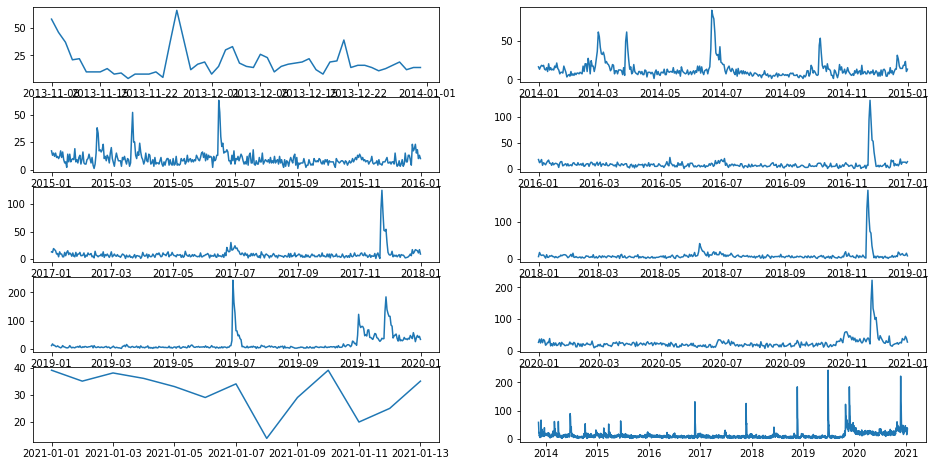

In [91]:
# Taking a look at number of reviews every year.

reviewcount13 = reviewcount['2013-01-01':'2013-12-31']
reviewcount14 = reviewcount['2014-01-01':'2014-12-31']
reviewcount15 = reviewcount['2015-01-01':'2015-12-31']
reviewcount16 = reviewcount['2016-01-01':'2016-12-31']
reviewcount17 = reviewcount['2017-01-01':'2017-12-31']
reviewcount18 = reviewcount['2018-01-01':'2018-12-31']
reviewcount19 = reviewcount['2019-01-01':'2019-12-31']
reviewcount20 = reviewcount['2020-01-01':'2020-12-31']
reviewcount21 = reviewcount['2021-01-01':'2021-12-31']

fig, axes = plt.subplots(5, 2, figsize=(16,8))

axes[0, 0].plot(reviewcount13)
axes[0, 1].plot(reviewcount14)
axes[1, 0].plot(reviewcount15)
axes[1, 1].plot(reviewcount16)
axes[2, 0].plot(reviewcount17)
axes[2, 1].plot(reviewcount18)
axes[3, 0].plot(reviewcount19)
axes[3, 1].plot(reviewcount20)
axes[4, 0].plot(reviewcount21)
axes[4, 1].plot(reviewcount)

plt.show()

In [92]:
def hampel(vals_orig, k=7, t0=3):
    
    # Don't overwrite original
    vals = vals_orig.copy()
    
    # Hampel Filter
    L = 1.4826
    rolling_median = vals.rolling(window=k, center=True).median()
    MAD = lambda x: np.median(np.abs(x - np.median(x)))
    rolling_MAD = vals.rolling(window=k, center=True).apply(MAD)
    threshold = t0 * L * rolling_MAD
    difference = np.abs(vals - rolling_median) 
    outlier_idx = difference > threshold
    vals[outlier_idx] = rolling_median[outlier_idx] 
    
    return(vals)

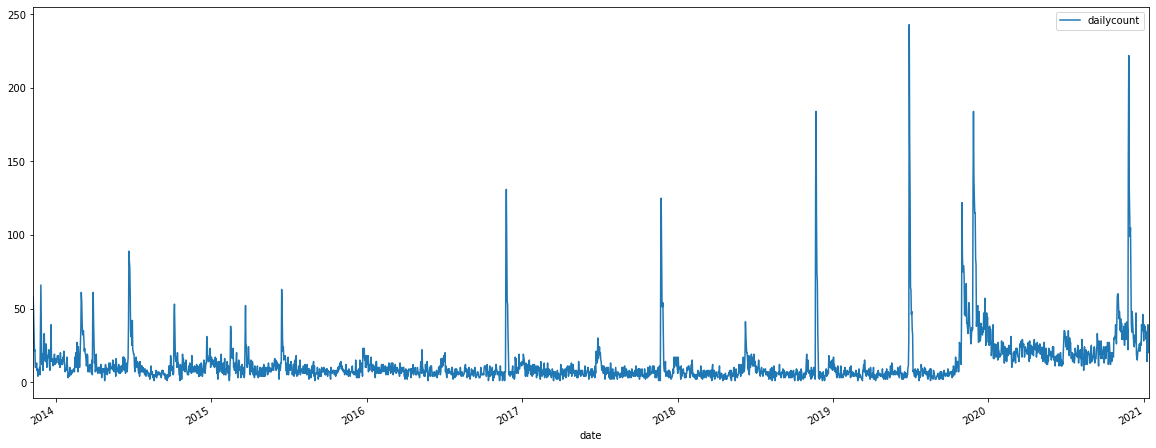

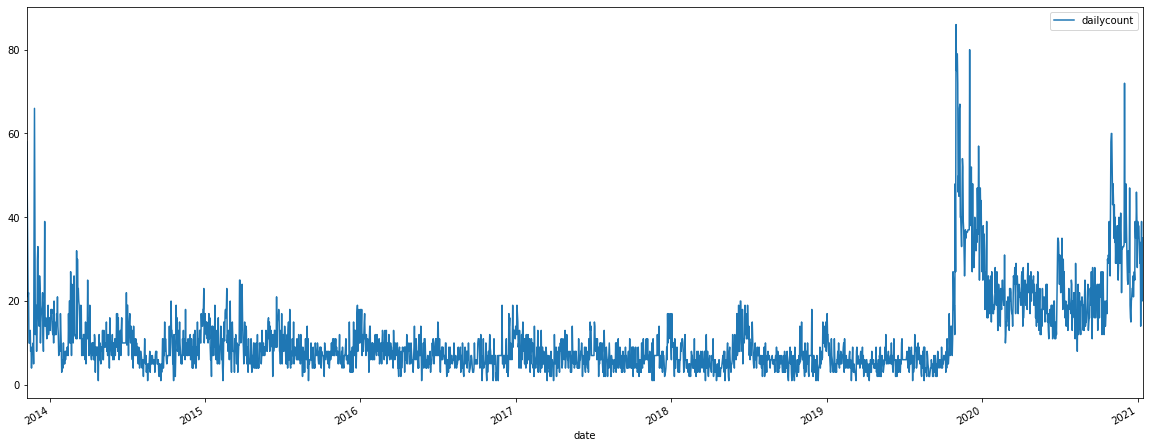

In [93]:
# k value chosen iteratively.

ts = reviewcount
hampts = hampel(ts, 90)

ts.plot(figsize = (20,8))
hampts.plot(figsize = (20,8))

plt.show()

In [94]:
# Adding a column with filtered values for later use.

reviewcount['dailycountfilter'] = pd.Series(hampts.values.flatten(), index=reviewcount.index)
reviewcount

,dailycount,dailycountfilter
date,,
2013-11-08,58,58.0
2013-11-09,46,46.0
2013-11-10,37,37.0
2013-11-11,21,21.0
2013-11-12,22,22.0
...,...,...
2021-01-09,29,29.0
2021-01-10,39,39.0
2021-01-11,20,20.0


In [95]:
# Checking how many values were changed from the original data.

reviewcount['filtered'] = np.where(reviewcount['dailycount'] == reviewcount['dailycountfilter'], True, False)
reviewcount['filtered'].value_counts()

True     2495
False     120
Name: filtered, dtype: int64

----

# Stationarity Tests

### Summary Statistics

Text(0.5, 1.0, 'Distribution of Daily # of Reviews')

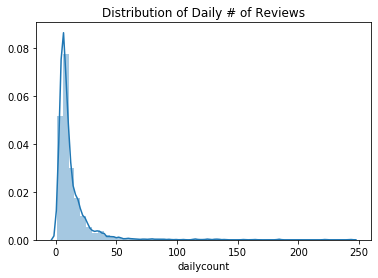

In [96]:
sns.distplot(reviewcount['dailycount'])
plt.title('Distribution of Daily # of Reviews')

In [97]:
X = reviewcount['dailycount'].values
split = round(len(X)/2)
X1, X2 = X[0:split], X[split:]
mean1, mean2 = X1.mean(),X2.mean()
var1, var2 = X1.var(), X2.var()
print('mean1=%f, mean2=%f' % (mean1, mean2))
print('variance1=%f, variance2=%f' % (var1, var2))

mean1=10.279052, mean2=15.719204
variance1=90.387726, variance2=438.074941


Text(0.5, 1.0, 'Distribution of Daily # of Reviews')

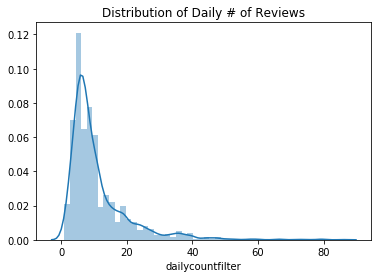

In [98]:
sns.distplot(reviewcount['dailycountfilter'])
plt.title('Distribution of Daily # of Reviews')

In [99]:
X = reviewcount['dailycountfilter'].values
split = round(len(X)/2)
X1, X2 = X[0:split], X[split:]
mean1, mean2 = X1.mean(),X2.mean()
var1, var2 = X1.var(), X2.var()
print('mean1=%f, mean2=%f' % (mean1, mean2))
print('variance1=%f, variance2=%f' % (var1, var2))

mean1=8.976300, mean2=13.084162
variance1=27.172603, variance2=142.413728


### Dickey-Fuller Test

In [100]:
# This data is stationary within critical value 1%

dftest = adfuller(reviewcount['dailycount'])

dfoutput = pd.Series(dftest[0:4], index=['Test Statistic', 'p-value', '#Lags Used', 'Number of Observations Used'])
for key,value in dftest[4].items():
    dfoutput['Critical Value (%s)'%key] = value
print(dftest)
print('----------------------------------')
print ('Results of Dickey-Fuller test: \n')

print(dfoutput)

(-4.899112181992308, 3.50133966639758e-05, 27, 2587, {'1%': -3.4328802668982084, '5%': -2.862657875000973, '10%': -2.5673650853551155}, 18845.897585169278)
----------------------------------
Results of Dickey-Fuller test: 

Test Statistic                   -4.899112
p-value                           0.000035
#Lags Used                       27.000000
Number of Observations Used    2587.000000
Critical Value (1%)              -3.432880
Critical Value (5%)              -2.862658
Critical Value (10%)             -2.567365
dtype: float64


In [101]:
# This data is stationary within critical value 5%.

dftest = adfuller(reviewcount['dailycountfilter'])

dfoutput = pd.Series(dftest[0:4], index=['Test Statistic', 'p-value', '#Lags Used', 'Number of Observations Used'])
for key,value in dftest[4].items():
    dfoutput['Critical Value (%s)'%key] = value
print(dftest)
print('----------------------------------')
print ('Results of Dickey-Fuller test: \n')

print(dfoutput)

(-2.655577187551462, 0.08204580849300558, 28, 2586, {'1%': -3.4328812463201746, '5%': -2.8626583075270813, '10%': -2.5673653156355627}, 15079.719574627758)
----------------------------------
Results of Dickey-Fuller test: 

Test Statistic                   -2.655577
p-value                           0.082046
#Lags Used                       28.000000
Number of Observations Used    2586.000000
Critical Value (1%)              -3.432881
Critical Value (5%)              -2.862658
Critical Value (10%)             -2.567365
dtype: float64


### Looking at ACF and PACF

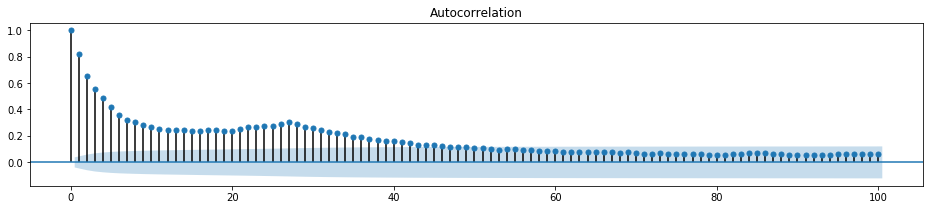

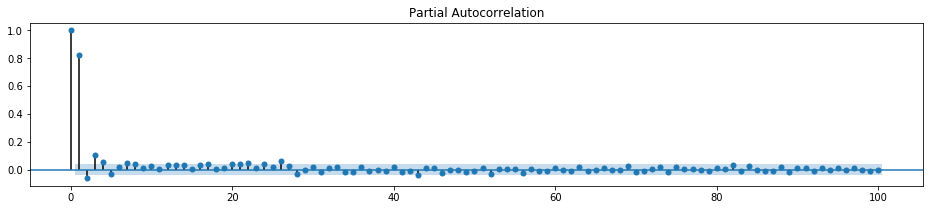

In [102]:
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf

fig, ax = plt.subplots(figsize=(16,3))
plot_acf(reviewcount['dailycount'], ax=ax, lags=100);

fig, ax = plt.subplots(figsize=(16,3))
plot_pacf(reviewcount['dailycount'], ax=ax, lags=100);

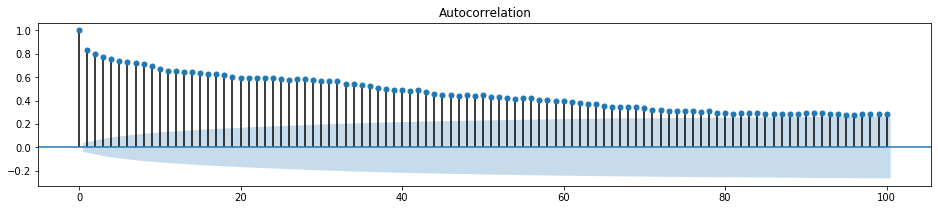

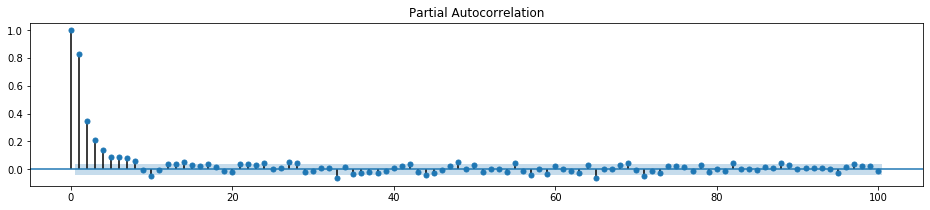

In [103]:
fig, ax = plt.subplots(figsize=(16,3))
plot_acf(reviewcount['dailycountfilter'], ax=ax, lags=100);

fig, ax = plt.subplots(figsize=(16,3))
plot_pacf(reviewcount['dailycountfilter'], ax=ax, lags=100);

------

# Forecast Modeling

In [104]:
# I chose this split date as the data is unusual due to a spike in reviews near the beginning of 2020.

split_date='2020-07-01'

train=reviewcount.loc[reviewcount.index <= split_date].copy()
test=reviewcount.loc[reviewcount.index > split_date].copy()

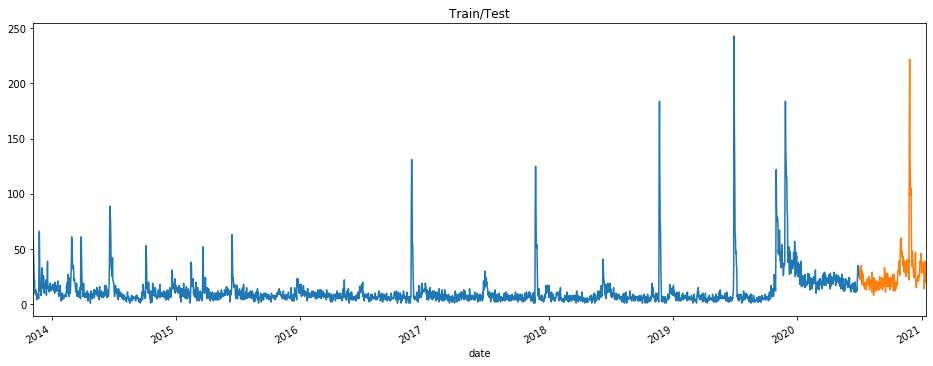

In [105]:
# Blue shows train data, orange shows test data.

train['dailycount'].plot(figsize=(16,6), title='Train/Test')
test['dailycount'].plot(figsize=(16,6), title='Train/Test')
plt.show()

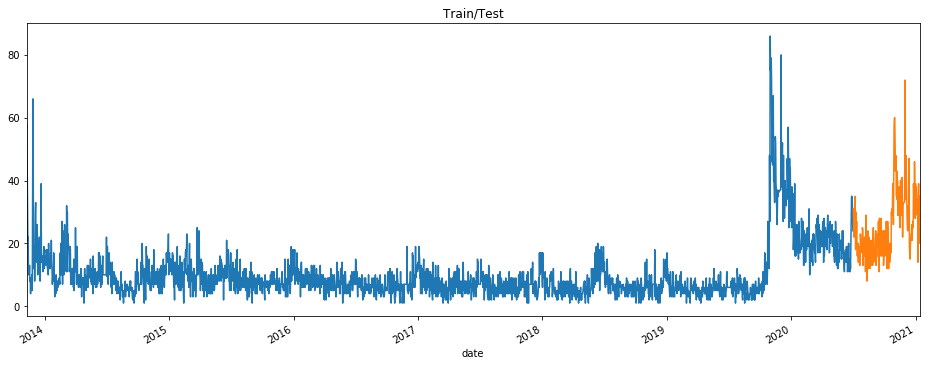

In [106]:
# Blue shows train data, orange shows test data.

train['dailycountfilter'].plot(figsize=(16,6), title='Train/Test')
test['dailycountfilter'].plot(figsize=(16,6), title='Train/Test')
plt.show()

----

## Naive Forecast

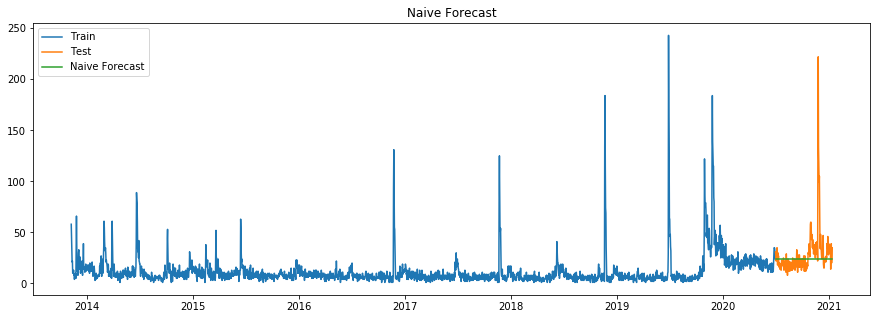

In [31]:
number = np.asarray(train['dailycount'])
y_hat = test.copy()
y_hat['naive'] = number[len(number)-1]

plt.figure(figsize=(15,5))
plt.plot(train.index, train['dailycount'], label='Train')
plt.plot(test.index,test['dailycount'], label='Test')
plt.plot(y_hat.index,y_hat['naive'], label='Naive Forecast')
plt.legend(loc='best')
plt.title("Naive Forecast")
plt.show()

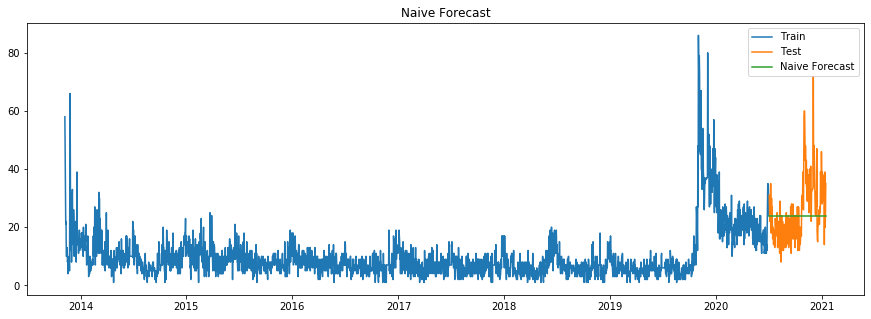

In [32]:
numberf = np.asarray(train['dailycountfilter'])
y_hatf = test.copy()
y_hatf['naive'] = number[len(number)-1]

plt.figure(figsize=(15,5))
plt.plot(train.index, train['dailycountfilter'], label='Train')
plt.plot(test.index,test['dailycountfilter'], label='Test')
plt.plot(y_hat.index,y_hatf['naive'], label='Naive Forecast')
plt.legend(loc='best')
plt.title("Naive Forecast")
plt.show()

In [33]:
def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

###########################################################

print(r2_score(y_true=test['dailycount'],
               y_pred=y_hat['naive']))

print(mean_squared_error(y_true=test['dailycount'],
                         y_pred=y_hat['naive']))

print(mean_absolute_error(y_true=test['dailycount'],
                         y_pred=y_hat['naive']))

print(mean_absolute_percentage_error(y_true=test['dailycount'],
                         y_pred=y_hat['naive']))

print(sqrt(mean_squared_error(test['dailycount'], y_hat['naive'])))


print('-------------------')

print(r2_score(y_true=test['dailycountfilter'],
               y_pred=y_hatf['naive']))

print(mean_squared_error(y_true=test['dailycountfilter'],
                         y_pred=y_hatf['naive']))

print(mean_absolute_error(y_true=test['dailycountfilter'],
                         y_pred=y_hatf['naive']))

print(mean_absolute_percentage_error(y_true=test['dailycountfilter'],
                         y_pred=y_hatf['naive']))

print(sqrt(mean_squared_error(test['dailycountfilter'], y_hatf['naive'])))

-0.04364652356950027
564.1122448979592
11.122448979591837
34.24892097861555
23.751047237921092
-------------------
-0.022196028116201916
109.69770408163265
7.85969387755102
32.581425187657466
10.473667174472972


----

## Prophet

In [107]:
# Normal Data fit to format required of Prophet

tsprophet = train.drop(columns=['dailycountfilter', 'filtered'])
tsprophet = tsprophet.reset_index()
tsprophet = tsprophet.rename(columns={'date':'ds', 'dailycount':'y'})

tsprophettest = test.drop(columns=['dailycountfilter', 'filtered'])
tsprophettest = tsprophettest.reset_index()
tsprophettest = tsprophettest.rename(columns={'date':'ds', 'dailycount':'y'})

# Filtered Data fit to format required of Prophet

tsprophetf = train.drop(columns=['dailycount', 'filtered'])
tsprophetf = tsprophetf.reset_index()
tsprophetf = tsprophetf.rename(columns={'date':'ds', 'dailycountfilter':'y'})

tsprophettestf = test.drop(columns=['dailycount', 'filtered'])
tsprophettestf = tsprophettestf.reset_index()
tsprophettestf = tsprophettestf.rename(columns={'date':'ds', 'dailycountfilter':'y'})

In [108]:
model = Prophet() 
model.fit(tsprophet) 

testforecast = model.predict(df=tsprophettest)
testforecast.head()

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2020-07-02,28.267254,19.439015,53.671438,28.267254,28.267254,9.017045,9.017045,9.017045,-0.796653,-0.796653,-0.796653,9.813697,9.813697,9.813697,0.0,0.0,0.0,37.284299
1,2020-07-03,28.303176,19.823665,54.347353,28.303176,28.303176,9.111015,9.111015,9.111015,-0.170404,-0.170404,-0.170404,9.281420,9.281420,9.281420,0.0,0.0,0.0,37.414192
2,2020-07-04,28.339098,21.604236,55.642181,28.339098,28.339098,10.054087,10.054087,10.054087,1.419037,1.419037,1.419037,8.635050,8.635050,8.635050,0.0,0.0,0.0,38.393186
3,2020-07-05,28.375020,21.414283,53.858099,28.375020,28.375020,9.013363,9.013363,9.013363,1.127449,1.127449,1.127449,7.885914,7.885914,7.885914,0.0,0.0,0.0,37.388383
4,2020-07-06,28.410942,19.999854,50.840442,28.410942,28.410942,6.795122,6.795122,6.795122,-0.252144,-0.252144,-0.252144,7.047266,7.047266,7.047266,0.0,0.0,0.0,35.206064


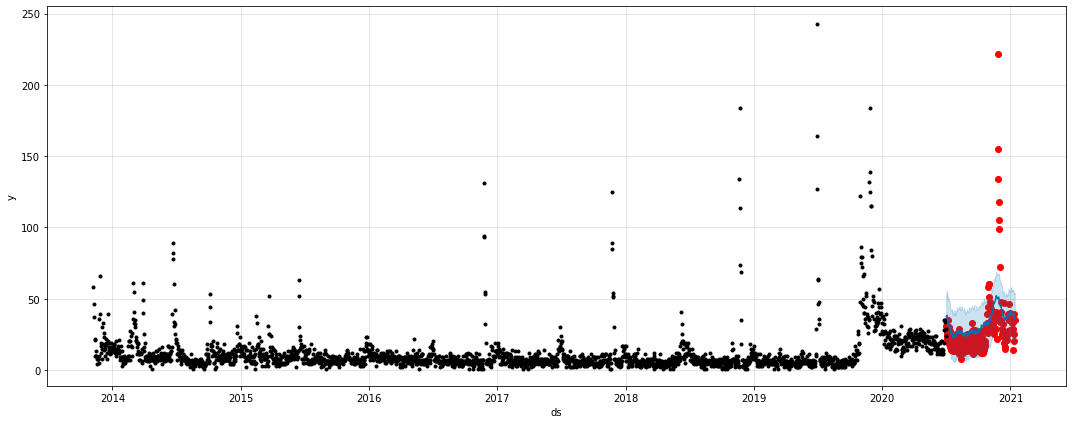

In [109]:
f, ax = plt.subplots(1)
f.set_figheight(6)
f.set_figwidth(15)
ax.scatter(tsprophettest['ds'],tsprophettest['y'], color='r')
fig = model.plot(testforecast, ax=ax)
plt.show()

In [110]:
model2 = Prophet() 
model2.fit(tsprophetf) 

testforecastf = model.predict(df=tsprophettestf)
testforecastf.head()

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2020-07-02,28.267254,19.695877,52.738286,28.267254,28.267254,9.017045,9.017045,9.017045,-0.796653,-0.796653,-0.796653,9.813697,9.813697,9.813697,0.0,0.0,0.0,37.284299
1,2020-07-03,28.303176,20.663128,54.655463,28.303176,28.303176,9.111015,9.111015,9.111015,-0.170404,-0.170404,-0.170404,9.281420,9.281420,9.281420,0.0,0.0,0.0,37.414192
2,2020-07-04,28.339098,21.944128,53.882437,28.339098,28.339098,10.054087,10.054087,10.054087,1.419037,1.419037,1.419037,8.635050,8.635050,8.635050,0.0,0.0,0.0,38.393186
3,2020-07-05,28.375020,20.953917,53.842050,28.375020,28.375020,9.013363,9.013363,9.013363,1.127449,1.127449,1.127449,7.885914,7.885914,7.885914,0.0,0.0,0.0,37.388383
4,2020-07-06,28.410942,18.276195,53.471754,28.410942,28.410942,6.795122,6.795122,6.795122,-0.252144,-0.252144,-0.252144,7.047266,7.047266,7.047266,0.0,0.0,0.0,35.206064


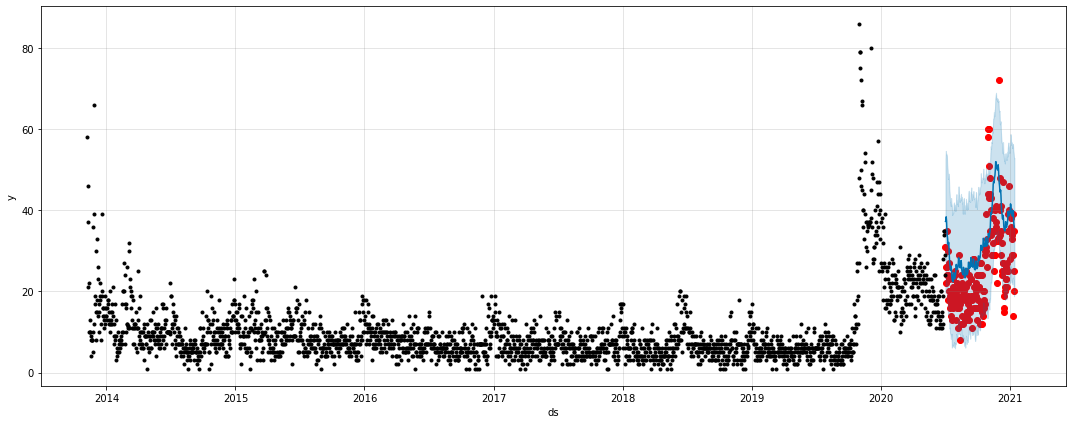

In [111]:
f, ax = plt.subplots(1)
f.set_figheight(6)
f.set_figwidth(15)
ax.scatter(tsprophettestf['ds'],tsprophettestf['y'], color='r')
fig = model2.plot(testforecastf, ax=ax)
plt.show()

In [112]:
print(r2_score(y_true=tsprophettest['y'],
               y_pred=testforecast['yhat']))

print(mean_squared_error(y_true=tsprophettest['y'],
                         y_pred=testforecast['yhat']))

print(mean_absolute_error(y_true=tsprophettest['y'],
                         y_pred=testforecast['yhat']))

print(mean_absolute_percentage_error(y_true=tsprophettest['y'],
                         y_pred=testforecast['yhat']))

print(sqrt(mean_squared_error(tsprophettest['y'], testforecast['yhat'])))

print('-------------------')

print(r2_score(y_true=tsprophettestf['y'],
               y_pred=testforecastf['yhat']))

print(mean_squared_error(y_true=tsprophettestf['y'],
                         y_pred=testforecastf['yhat']))

print(mean_absolute_error(y_true=tsprophettestf['y'],
                         y_pred=testforecastf['yhat']))

print(mean_absolute_percentage_error(y_true=tsprophettestf['y'],
                         y_pred=testforecastf['yhat']))

print(sqrt(mean_squared_error(tsprophettestf['y'], testforecastf['yhat'])))

0.24708421512042555
406.96634735567284
11.534701969750031
44.53169378768569
20.173406934766195
-------------------
-0.13874712272895096
122.20546886994023
9.361287241080731
44.41705405936208
11.054658243018652


### Hyperparameter Tuning (Prophet)

In [123]:
import holidays

holiday = pd.DataFrame([])
for date, name in sorted(holidays.UnitedStates(years=[2020, 2021]).items()):
    holiday = holiday.append(pd.DataFrame({'ds': date, 'holiday': "US-Holidays"}, index=[0]), ignore_index=True)
holiday['ds'] = pd.to_datetime(holiday['ds'], format='%Y-%m-%d', errors='ignore')

holiday.head()

,ds,holiday
0,2020-01-01,US-Holidays
1,2020-01-20,US-Holidays
2,2020-02-17,US-Holidays
3,2020-05-25,US-Holidays
4,2020-07-03,US-Holidays


In [191]:
# It takes about 5 minutes to run 48 different models.

from sklearn.model_selection import ParameterGrid
params_grid = {'seasonality_mode': ('additive', 'multiplicative'),
               'changepoint_prior_scale': [0.05,0.1],
              'holidays_prior_scale': [0.05,0.1,0.5,1.0],
              'n_changepoints': [50,100,150]}
grid = ParameterGrid(params_grid)

In [206]:
strt='2020-07-02'
end='2021-01-14'

strtt = datetime.strptime(strt, '%Y-%m-%d')
endt = datetime.strptime(end, '%Y-%m-%d')

model_parameters = pd.DataFrame(columns = ['RMSE','MAE','Parameters'])

########

starttime = datetime.now()

########

for p in grid:
    test = pd.DataFrame()
    print(p)
    train_model =Prophet(changepoint_prior_scale = p['changepoint_prior_scale'],
                         holidays_prior_scale = p['holidays_prior_scale'],
                         n_changepoints = p['n_changepoints'],
                         seasonality_mode = p['seasonality_mode'],
                         weekly_seasonality = True,
                         daily_seasonality = True,
                         yearly_seasonality = True,
                         holidays=holiday, 
                         interval_width=0.95)
    train_model.add_country_holidays(country_name='US')
    train_model.fit(tsprophet)
    train_forecast = train_model.make_future_dataframe(periods=(endt-strtt).days, freq='D',include_history = False)
    train_forecast = train_model.predict(train_forecast)
    test=train_forecast[['ds','yhat']]
    RMSE = (sqrt(mean_squared_error(tsprophettest['y'],abs(test['yhat']))))
    MAE = (mean_absolute_error(tsprophettestf['y'],test['yhat']))
    print('Root Mean Squared Error(RMSE)------------------------------------',RMSE)
    print('Mean Absolute Error(MAE)------------------------------------',MAE)
    model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'Parameters':p},ignore_index=True)
    
########

print(datetime.now() - starttime)

{'changepoint_prior_scale': 0.05, 'holidays_prior_scale': 0.05, 'n_changepoints': 50, 'seasonality_mode': 'additive'}
Root Mean Squared Error(RMSE)------------------------------------ 18.37177709113074
Mean Absolute Error(MAE)------------------------------------ 9.264778714640535
{'changepoint_prior_scale': 0.05, 'holidays_prior_scale': 0.05, 'n_changepoints': 50, 'seasonality_mode': 'multiplicative'}
Root Mean Squared Error(RMSE)------------------------------------ 26.96525045950638
Mean Absolute Error(MAE)------------------------------------ 19.099109200621097
{'changepoint_prior_scale': 0.05, 'holidays_prior_scale': 0.05, 'n_changepoints': 100, 'seasonality_mode': 'additive'}
Root Mean Squared Error(RMSE)------------------------------------ 18.378267163788056
Mean Absolute Error(MAE)------------------------------------ 9.275547504812804
{'changepoint_prior_scale': 0.05, 'holidays_prior_scale': 0.05, 'n_changepoints': 100, 'seasonality_mode': 'multiplicative'}
Root Mean Squared Error

Root Mean Squared Error(RMSE)------------------------------------ 26.303918762017922
Mean Absolute Error(MAE)------------------------------------ 18.457360200222592
{'changepoint_prior_scale': 0.1, 'holidays_prior_scale': 0.1, 'n_changepoints': 50, 'seasonality_mode': 'additive'}
Root Mean Squared Error(RMSE)------------------------------------ 18.32035560081636
Mean Absolute Error(MAE)------------------------------------ 9.633973124017288
{'changepoint_prior_scale': 0.1, 'holidays_prior_scale': 0.1, 'n_changepoints': 50, 'seasonality_mode': 'multiplicative'}
Root Mean Squared Error(RMSE)------------------------------------ 18.947577832921255
Mean Absolute Error(MAE)------------------------------------ 14.843371991872367
{'changepoint_prior_scale': 0.1, 'holidays_prior_scale': 0.1, 'n_changepoints': 100, 'seasonality_mode': 'additive'}
Root Mean Squared Error(RMSE)------------------------------------ 18.308852965806196
Mean Absolute Error(MAE)------------------------------------ 9.6062

In [212]:
parametersRMSE = model_parameters.sort_values(by=['RMSE'])
parametersRMSE = parametersRMSE.reset_index(drop=True)

parametersRMSE.head(10)

,RMSE,MAE,Parameters
0,18.143097,9.256296,"{'changepoint_prior_scale': 0.05, 'holidays_pr..."
1,18.151903,9.263723,"{'changepoint_prior_scale': 0.05, 'holidays_pr..."
2,18.162843,9.286036,"{'changepoint_prior_scale': 0.05, 'holidays_pr..."
3,18.164030,9.283405,"{'changepoint_prior_scale': 0.05, 'holidays_pr..."
4,18.167422,9.342738,"{'changepoint_prior_scale': 0.05, 'holidays_pr..."
5,18.167997,9.285503,"{'changepoint_prior_scale': 0.05, 'holidays_pr..."
6,18.208321,9.247874,"{'changepoint_prior_scale': 0.05, 'holidays_pr..."
7,18.219263,9.302241,"{'changepoint_prior_scale': 0.05, 'holidays_pr..."
8,18.225464,9.339379,"{'changepoint_prior_scale': 0.05, 'holidays_pr..."
9,18.255575,9.607981,"{'changepoint_prior_scale': 0.1, 'holidays_pri..."


In [213]:
parametersMAE = model_parameters.sort_values(by=['MAE'])
parametersMAE = parametersMAE.reset_index(drop=True)

parametersMAE.head(10)

,RMSE,MAE,Parameters
0,18.208321,9.247874,"{'changepoint_prior_scale': 0.05, 'holidays_pr..."
1,18.143097,9.256296,"{'changepoint_prior_scale': 0.05, 'holidays_pr..."
2,18.151903,9.263723,"{'changepoint_prior_scale': 0.05, 'holidays_pr..."
3,18.371777,9.264779,"{'changepoint_prior_scale': 0.05, 'holidays_pr..."
4,18.378267,9.275548,"{'changepoint_prior_scale': 0.05, 'holidays_pr..."
5,18.164030,9.283405,"{'changepoint_prior_scale': 0.05, 'holidays_pr..."
6,18.167997,9.285503,"{'changepoint_prior_scale': 0.05, 'holidays_pr..."
7,18.162843,9.286036,"{'changepoint_prior_scale': 0.05, 'holidays_pr..."
8,18.387252,9.302136,"{'changepoint_prior_scale': 0.05, 'holidays_pr..."
9,18.219263,9.302241,"{'changepoint_prior_scale': 0.05, 'holidays_pr..."


In [214]:
# changepoint_prior_scale indicates how flexible the changepoints are allowed to be. 
# holiday_prior_scale is used for smoothing the effect of holidays.
# n_changepoints is the number of changes happening in the data.
# seasonality_mode is whether effect of seasonality is additive or multiplicative.

list(parametersRMSE['Parameters'])[:10]

[{'changepoint_prior_scale': 0.05,
  'holidays_prior_scale': 0.5,
  'n_changepoints': 150,
  'seasonality_mode': 'additive'},
 {'changepoint_prior_scale': 0.05,
  'holidays_prior_scale': 1.0,
  'n_changepoints': 100,
  'seasonality_mode': 'additive'},
 {'changepoint_prior_scale': 0.05,
  'holidays_prior_scale': 1.0,
  'n_changepoints': 150,
  'seasonality_mode': 'additive'},
 {'changepoint_prior_scale': 0.05,
  'holidays_prior_scale': 0.5,
  'n_changepoints': 100,
  'seasonality_mode': 'additive'},
 {'changepoint_prior_scale': 0.05,
  'holidays_prior_scale': 1.0,
  'n_changepoints': 50,
  'seasonality_mode': 'additive'},
 {'changepoint_prior_scale': 0.05,
  'holidays_prior_scale': 0.5,
  'n_changepoints': 50,
  'seasonality_mode': 'additive'},
 {'changepoint_prior_scale': 0.05,
  'holidays_prior_scale': 0.1,
  'n_changepoints': 100,
  'seasonality_mode': 'additive'},
 {'changepoint_prior_scale': 0.05,
  'holidays_prior_scale': 0.1,
  'n_changepoints': 150,
  'seasonality_mode': 'additi

In [215]:
list(parametersMAE['Parameters'])[:10]

[{'changepoint_prior_scale': 0.05,
  'holidays_prior_scale': 0.1,
  'n_changepoints': 100,
  'seasonality_mode': 'additive'},
 {'changepoint_prior_scale': 0.05,
  'holidays_prior_scale': 0.5,
  'n_changepoints': 150,
  'seasonality_mode': 'additive'},
 {'changepoint_prior_scale': 0.05,
  'holidays_prior_scale': 1.0,
  'n_changepoints': 100,
  'seasonality_mode': 'additive'},
 {'changepoint_prior_scale': 0.05,
  'holidays_prior_scale': 0.05,
  'n_changepoints': 50,
  'seasonality_mode': 'additive'},
 {'changepoint_prior_scale': 0.05,
  'holidays_prior_scale': 0.05,
  'n_changepoints': 100,
  'seasonality_mode': 'additive'},
 {'changepoint_prior_scale': 0.05,
  'holidays_prior_scale': 0.5,
  'n_changepoints': 100,
  'seasonality_mode': 'additive'},
 {'changepoint_prior_scale': 0.05,
  'holidays_prior_scale': 0.5,
  'n_changepoints': 50,
  'seasonality_mode': 'additive'},
 {'changepoint_prior_scale': 0.05,
  'holidays_prior_scale': 1.0,
  'n_changepoints': 150,
  'seasonality_mode': 'addi

### Final Model (Prophet)

In [216]:
final_model = Prophet(holidays=holiday,
                      changepoint_prior_scale= 0.05,
                      holidays_prior_scale = 0.5,
                      n_changepoints = 150,
                      seasonality_mode = 'additive',
                      weekly_seasonality=True,
                      daily_seasonality = True,
                      yearly_seasonality = True,
                      interval_width=0.95)
final_model.add_country_holidays(country_name='US')
final_model.fit(tsprophet)

In [217]:
future = final_model.make_future_dataframe(periods=(endt-strtt).days, freq='D')
forecast = final_model.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail(10)

,ds,yhat,yhat_lower,yhat_upper
2605,2021-01-04,39.525971,16.056004,64.158513
2606,2021-01-05,38.898413,17.031014,61.672224
2607,2021-01-06,38.821609,15.917329,62.097038
2608,2021-01-07,36.970270,12.366753,62.152058
2609,2021-01-08,38.575695,13.677057,62.789287
2610,2021-01-09,39.706736,15.109697,65.887494
2611,2021-01-10,38.949837,14.721764,62.381252
2612,2021-01-11,37.019730,12.410335,60.777894
2613,2021-01-12,36.086910,13.929202,60.816504
2614,2021-01-13,35.761208,11.981882,61.797815


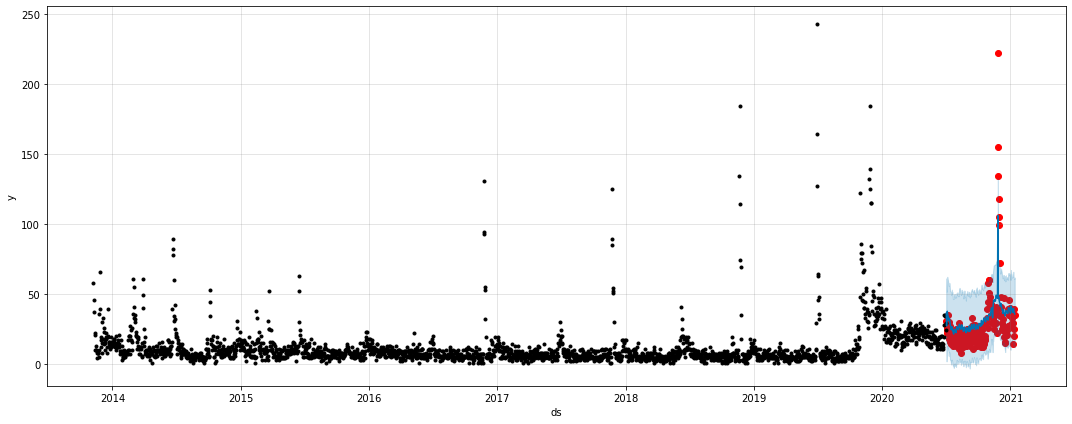

In [218]:
f, ax = plt.subplots(1)
f.set_figheight(6)
f.set_figwidth(15)
ax.scatter(tsprophettest['ds'],tsprophettest['y'], color='r')
fig = model.plot(forecast[-196:], ax=ax)
plt.show()

In [219]:
print(r2_score(y_true=tsprophettest['y'],
               y_pred=forecast['yhat'][-196:]))

print(mean_squared_error(y_true=tsprophettest['y'],
                         y_pred=forecast['yhat'][-196:]))

print(mean_absolute_error(y_true=tsprophettest['y'],
                         y_pred=forecast['yhat'][-196:]))

print(mean_absolute_percentage_error(y_true=tsprophettest['y'],
                         y_pred=forecast['yhat'][-196:]))

print(sqrt(mean_squared_error(tsprophettest['y'], forecast['yhat'][-196:])))

0.39100914287857946
329.171986658967
11.018821968618873
43.47672329014908
18.143097493508847


Compare to:

- 0.24708421512042555
- 406.96634735567284
- 11.534701969750031
- 44.53169378768569
- 20.173406934766195

## XGBoost

In [253]:
# transform a time series dataset into a supervised learning dataset
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = DataFrame(data)
    cols = list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
    # put it all together
    agg = concat(cols, axis=1)
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg.values
 
# split a univariate dataset into train/test sets
def train_test_split(data, n_test):
    return data[:-n_test, :], data[-n_test:, :]
 
# fit an xgboost model and make a one step prediction
def xgboost_forecast(train, testX):
    # transform list into array
    train = asarray(train)
    # split into input and output columns
    trainX, trainy = train[:, :-1], train[:, -1]
    # fit model
    model = XGBRegressor(objective='reg:squarederror', n_estimators=1000)
    model.fit(trainX, trainy)
    # make a one-step prediction
    yhat = model.predict(asarray([testX]))
    return yhat[0]
 
# walk-forward validation for univariate data
def walk_forward_validation(data, n_test):
    predictions = list()
    # split dataset
    train, test = train_test_split(data, n_test)
    # seed history with training dataset
    history = [x for x in train]
    # step over each time-step in the test set
    for i in range(len(test)):
        # split test row into input and output columns
        testX, testy = test[i, :-1], test[i, -1]
        # fit model on history and make a prediction
        yhat = xgboost_forecast(history, testX)
        # store forecast in list of predictions
        predictions.append(yhat)
        # add actual observation to history for the next loop
        history.append(test[i])
        # summarize progress
        print('>expected=%.1f, predicted=%.1f' % (testy, yhat))
    # estimate prediction error
    rmse = sqrt(mean_squared_error(test[:, -1], predictions))
    mae = mean_absolute_error(test[:, -1], predictions)

    return rmse, mae, test[:, -1], predictions

In [257]:
values = list(reviewcount['dailycount'].values)

tsdata = series_to_supervised(values, n_in=14)

starttime = datetime.now()

########

rmse, mae, y, yhat = walk_forward_validation(tsdata, 196)

print('RMSE: %.3f' % rmse)
print('MAE: %.3f' % mae)

########

print(datetime.now() - starttime)

>expected=31.0, predicted=19.7
>expected=26.0, predicted=29.5
>expected=22.0, predicted=24.9
>expected=24.0, predicted=20.0
>expected=26.0, predicted=20.6
>expected=35.0, predicted=22.9
>expected=24.0, predicted=30.3
>expected=18.0, predicted=21.6
>expected=30.0, predicted=19.6
>expected=23.0, predicted=34.3
>expected=27.0, predicted=21.1
>expected=20.0, predicted=25.3
>expected=16.0, predicted=26.0
>expected=19.0, predicted=22.2
>expected=20.0, predicted=19.9
>expected=14.0, predicted=22.9
>expected=19.0, predicted=16.2
>expected=17.0, predicted=13.2
>expected=19.0, predicted=20.9
>expected=13.0, predicted=16.4
>expected=16.0, predicted=20.2
>expected=23.0, predicted=18.6
>expected=21.0, predicted=16.5
>expected=19.0, predicted=16.8
>expected=18.0, predicted=17.7
>expected=19.0, predicted=18.5
>expected=17.0, predicted=18.0
>expected=25.0, predicted=17.8
>expected=24.0, predicted=21.2
>expected=13.0, predicted=19.8
>expected=20.0, predicted=17.5
>expected=20.0, predicted=20.6
>expecte

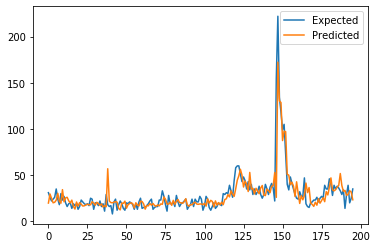

In [258]:
pyplot.plot(y, label='Expected')
pyplot.plot(yhat, label='Predicted')
pyplot.legend()
pyplot.show()

In [40]:
def create_features(dfx, label=None):

    dfx['date'] = dfx.index
    dfx['dayofweek'] = dfx['date'].dt.dayofweek
    dfx['quarter'] = dfx['date'].dt.quarter
    dfx['month'] = dfx['date'].dt.month
    dfx['year'] = dfx['date'].dt.year
    dfx['dayofyear'] = dfx['date'].dt.dayofyear
    dfx['dayofmonth'] = dfx['date'].dt.day
    dfx['weekofyear'] = dfx['date'].dt.weekofyear
    
    X = dfx[['dayofweek','quarter','month','year',
           'dayofyear','dayofmonth','weekofyear']]
    if label:
        y = dfx[label]
        return X, y
    return X

In [41]:
X_train, y_train = create_features(train, label='dailycount')
X_test, y_test = create_features(test, label='dailycount')

X_trainf, y_trainf = create_features(train, label='dailycountfilter')
X_testf, y_testf = create_features(test, label='dailycountfilter')

In [42]:
reg = xgb.XGBRegressor(n_estimators=1000)
regf = xgb.XGBRegressor(n_estimators=1000)

reg.fit(X_train, y_train,
        eval_set=[(X_train, y_train), (X_test, y_test)],
        early_stopping_rounds=50,
       verbose=False)

regf.fit(X_trainf, y_trainf,
        eval_set=[(X_trainf, y_trainf), (X_testf, y_testf)],
        early_stopping_rounds=50,
       verbose=False)

[19:50:23] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:50:23] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


XGBRegressor(n_estimators=1000)

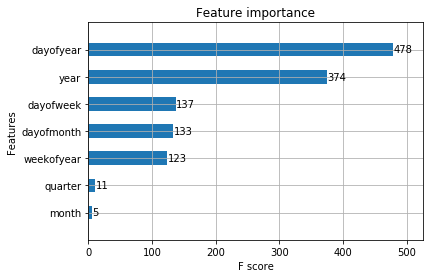

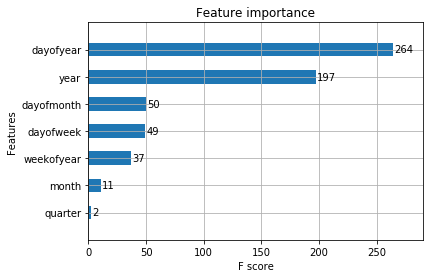

In [43]:
_ = plot_importance(reg, height=0.5)
_ = plot_importance(regf, height=0.5)

In [44]:
test['prediction'] = reg.predict(X_test)
test['predictionf'] = reg.predict(X_testf)

dfall = pd.concat([test, train], sort=False)

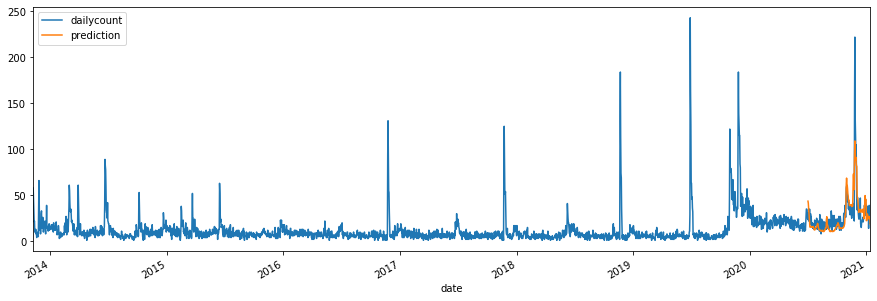

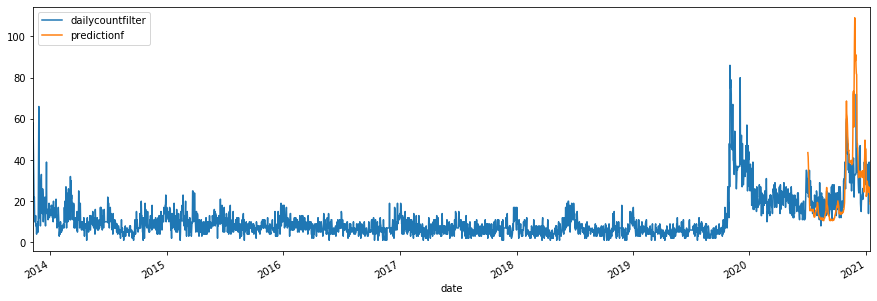

In [45]:
_ = dfall[['dailycount','prediction']].plot(figsize=(15, 5))
_ = dfall[['dailycountfilter','predictionf']].plot(figsize=(15, 5))

In [46]:
print(r2_score(y_true=test['dailycount'],
               y_pred=test['prediction']))

print(mean_squared_error(y_true=test['dailycount'],
                         y_pred=test['prediction']))

print(mean_absolute_error(y_true=test['dailycount'],
                         y_pred=test['prediction']))

print(mean_absolute_percentage_error(y_true=test['dailycount'],
                         y_pred=test['prediction']))

print(sqrt(mean_squared_error(test['dailycount'], test['prediction'])))

print('-------------------')

print(r2_score(y_true=test['dailycountfilter'],
               y_pred=test['predictionf']))

print(mean_squared_error(y_true=test['dailycountfilter'],
                         y_pred=test['predictionf']))

print(mean_absolute_error(y_true=test['dailycountfilter'],
                         y_pred=test['predictionf']))

print(mean_absolute_percentage_error(y_true=test['dailycountfilter'],
                         y_pred=test['predictionf']))

print(sqrt(mean_squared_error(test['dailycountfilter'], test['predictionf'])))

0.6235531409606847
203.47720989970986
8.818258334179314
30.725074742851348
14.26454380271973
-------------------
-1.0723830278131445
222.39927946873314
9.268972445507439
35.46063322499003
14.913057348133988


### Hyperparameter Tuning (XGBoost)

## pmdarima

In [47]:
adftest = ADFTest(alpha=0.05)

print(adftest.should_diff(reviewcount['dailycount']))
print(adftest.should_diff(reviewcount['dailycountfilter']))

(0.01, False)
(0.01, False)


In [48]:
# If done using full stepwise then:
# Best model:  ARIMA(5,1,0)(5,1,0)[12]          
# Total fit time: 1272.888 seconds

autoarima = auto_arima(train['dailycount'], start_p=5, d=1, start_q=0,
                       max_p=5, max_d=2, max_q=2, start_P=5,
                       D=1, start_Q=0, max_P=5, max_D=2,
                       max_Q=2, m=12, seasonal=True,
                       error_action='warn', trace=True,
                       supress_warnings=True, stepwise=True,
                       random_state=55, n_fits=50)

Performing stepwise search to minimize aic
 ARIMA(5,1,0)(5,1,0)[12]             : AIC=17842.787, Time=11.66 sec
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=19303.139, Time=0.11 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=18559.890, Time=0.54 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=inf, Time=3.00 sec
 ARIMA(5,1,0)(4,1,0)[12]             : AIC=17893.787, Time=7.28 sec
 ARIMA(5,1,0)(5,1,1)[12]             : AIC=inf, Time=140.58 sec
 ARIMA(5,1,0)(4,1,1)[12]             : AIC=inf, Time=90.21 sec
 ARIMA(4,1,0)(5,1,0)[12]             : AIC=17859.873, Time=14.63 sec
 ARIMA(5,1,1)(5,1,0)[12]             : AIC=inf, Time=123.20 sec
 ARIMA(4,1,1)(5,1,0)[12]             : AIC=inf, Time=95.13 sec
 ARIMA(5,1,0)(5,1,0)[12] intercept   : AIC=17844.770, Time=79.70 sec

Best model:  ARIMA(5,1,0)(5,1,0)[12]          
Total fit time: 566.088 seconds


In [49]:
autoarima.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                                  y   No. Observations:                 2419
Model:             SARIMAX(5, 1, 0)x(5, 1, 0, 12)   Log Likelihood               -8910.394
Date:                            Sun, 21 Feb 2021   AIC                          17842.787
Time:                                    20:07:04   BIC                          17906.430
Sample:                                         0   HQIC                         17865.938
                                           - 2419                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0714      0.005    -13.009      0.000      -0.082      -0.061
ar.L2         -0.1760      0.011    -15.699      0.000      -0.198      -0.154
ar.L3         -0.1630      0.009    -18.238      0.000      -0.181      -0.145
ar.L4         -0.0366      0.015     -2.447      0.014      -0.066      -0.007
ar.L5         -0.0890      0.012     -7.542      0.000      -0.112      -0.066
ar.S.L12      -0.8673      0.009    -92.061      0.000      -0.886      -0.849
ar.S.L24      -0.6732      0.012    -54.597      0.000      -0.697      -0.649
ar.S.L36      -0.4919      0.013    -37.273      0.000      -0.518      -0.466
ar.S.L48      -0.3266      0.013    -25.704      0.000      -0.352      -0.302
ar.S.L60      -0.1480      0.010    -14.284      0.000      -0.168      -0.128
sigma2        95.9406      0.351    272.969      0.000      95.252      96.629
===================================================================================
Ljung-Box (L1) (Q):                   0.18   Jarque-Bera (JB):           1666529.34
Prob(Q):                              0.67   Prob(JB):                         0.00
Heteroskedasticity (H):               3.38   Skew:                             6.63
Prob(H) (two-sided):                  0.00   Kurtosis:                       131.25
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [50]:
autoarimapredict = pd.DataFrame(autoarima.predict(n_periods=196), index=test.index)
autoarimapredict.columns = ['predicted']
autoarimapredict.head()

,predicted
date,
2020-07-02,24.879089
2020-07-03,27.250080
2020-07-04,24.236779
2020-07-05,24.613715
2020-07-06,27.470936


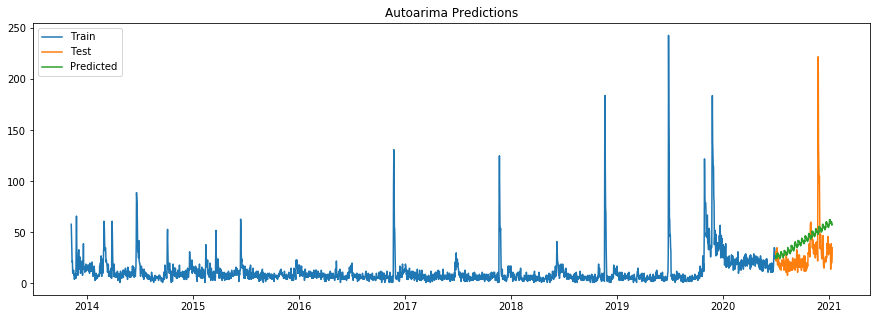

In [51]:
plt.figure(figsize=(15,5))
plt.plot(train.index, train['dailycount'], label='Train')
plt.plot(test.index, test['dailycount'], label='Test')
plt.plot(autoarimapredict.index, autoarimapredict['predicted'], label='Predicted')
plt.legend(loc='best')
plt.title("Autoarima Predictions")
plt.show()

In [52]:
print(r2_score(y_true=test['dailycount'],
               y_pred=autoarimapredict['predicted']))

print(mean_squared_error(y_true=test['dailycount'],
                         y_pred=autoarimapredict['predicted']))

print(mean_absolute_error(y_true=test['dailycount'],
                         y_pred=autoarimapredict['predicted']))

print(mean_absolute_percentage_error(y_true=test['dailycount'],
                         y_pred=autoarimapredict['predicted']))

print(sqrt(mean_squared_error(test['dailycount'], autoarimapredict['predicted'])))

-0.2458540094233741
673.4095176853627
19.712605874728695
84.04734843302037
25.95013521516531


In [53]:
#Best model:  ARIMA(1,1,2)(5,1,0)[12]          
#Total fit time: 1987.414 seconds

autoarimaf = auto_arima(train['dailycountfilter'], start_p=0, d=1, start_q=0,
                       max_p=5, max_d=1, max_q=5, start_P=5,
                       D=1, start_Q=0, max_P=5, max_D=5,
                       max_Q=5, m=12, seasonal=True,
                       error_action='warn', trace=True,
                       supress_warnings=True, stepwise=True,
                       random_state=55, n_fits=50)

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(5,1,0)[12]             : AIC=15060.870, Time=4.47 sec
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=16434.288, Time=0.08 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=15190.627, Time=0.44 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=inf, Time=1.52 sec
 ARIMA(0,1,0)(4,1,0)[12]             : AIC=15115.745, Time=2.77 sec
 ARIMA(0,1,0)(5,1,1)[12]             : AIC=inf, Time=33.65 sec
 ARIMA(0,1,0)(4,1,1)[12]             : AIC=inf, Time=20.03 sec
 ARIMA(1,1,0)(5,1,0)[12]             : AIC=14609.748, Time=7.84 sec
 ARIMA(1,1,0)(4,1,0)[12]             : AIC=14654.967, Time=5.40 sec
 ARIMA(1,1,0)(5,1,1)[12]             : AIC=inf, Time=43.17 sec
 ARIMA(1,1,0)(4,1,1)[12]             : AIC=inf, Time=27.77 sec
 ARIMA(2,1,0)(5,1,0)[12]             : AIC=14491.832, Time=11.82 sec
 ARIMA(2,1,0)(4,1,0)[12]             : AIC=14530.835, Time=7.10 sec
 ARIMA(2,1,0)(5,1,1)[12]             : AIC=inf, Time=50.14 sec
 ARIMA(2,1,0)(4,1,1)[12]           

In [54]:
autoarimaf.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                      
===========================================================================================
Dep. Variable:                                   y   No. Observations:                 2419
Model:             SARIMAX(1, 1, 2)x(5, 1, [], 12)   Log Likelihood               -7172.378
Date:                             Sun, 21 Feb 2021   AIC                          14362.756
Time:                                     20:49:55   BIC                          14414.827
Sample:                                          0   HQIC                         14381.697
                                            - 2419                                         
Covariance Type:                               opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.8015      0.037     21.934      0.000       0.730       0.873
ma.L1         -1.3955      0.042    -33.487      0.000      -1.477      -1.314
ma.L2          0.4442      0.031     14.199      0.000       0.383       0.506
ar.S.L12      -0.9043      0.014    -65.886      0.000      -0.931      -0.877
ar.S.L24      -0.7062      0.020    -34.613      0.000      -0.746      -0.666
ar.S.L36      -0.5318      0.021    -25.835      0.000      -0.572      -0.491
ar.S.L48      -0.3240      0.019    -17.126      0.000      -0.361      -0.287
ar.S.L60      -0.1413      0.016     -8.758      0.000      -0.173      -0.110
sigma2        22.6066      0.235     96.248      0.000      22.146      23.067
===================================================================================
Ljung-Box (L1) (Q):                   0.19   Jarque-Bera (JB):             35189.52
Prob(Q):                              0.66   Prob(JB):                         0.00
Heteroskedasticity (H):               1.21   Skew:                             1.67
Prob(H) (two-sided):                  0.01   Kurtosis:                        21.44
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [55]:
autoarimafpredict = pd.DataFrame(autoarimaf.predict(n_periods=196), index=test.index)
autoarimafpredict.columns = ['predicted']
autoarimafpredict.head()

,predicted
date,
2020-07-02,26.408835
2020-07-03,26.576902
2020-07-04,22.182565
2020-07-05,21.957433
2020-07-06,24.611920


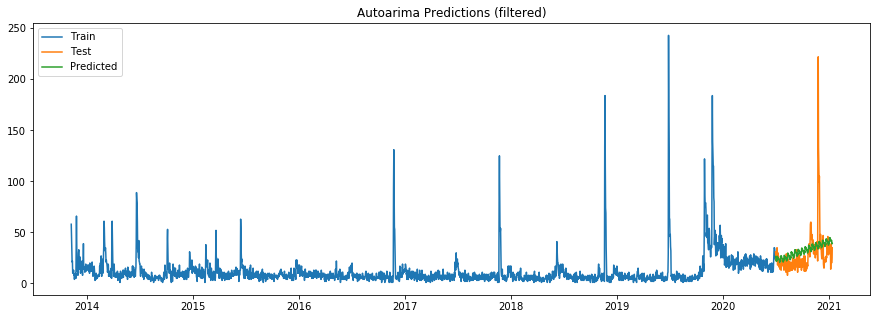

In [56]:
plt.figure(figsize=(15,5))
plt.plot(train.index, train['dailycount'], label='Train')
plt.plot(test.index, test['dailycount'], label='Test')
plt.plot(autoarimafpredict.index, autoarimafpredict['predicted'], label='Predicted')
plt.legend(loc='best')
plt.title("Autoarima Predictions (filtered)")
plt.show()

In [57]:
print(r2_score(y_true=test['dailycount'],
               y_pred=autoarimafpredict['predicted']))

print(mean_squared_error(y_true=test['dailycount'],
                         y_pred=autoarimafpredict['predicted']))

print(mean_absolute_error(y_true=test['dailycount'],
                         y_pred=autoarimafpredict['predicted']))

print(mean_absolute_percentage_error(y_true=test['dailycount'],
                         y_pred=autoarimafpredict['predicted']))

print(sqrt(mean_squared_error(test['dailycount'], autoarimafpredict['predicted'])))

0.06979314156227223
502.79579079902936
12.167955694244535
47.560921617702824
22.42310841072284


## LSTM network

In [58]:
print(len(train['dailycount']))
print(len(test['dailycount']))

2419
196


In [59]:
def timeseries_to_supervised(data, lag=1):
    df = pd.DataFrame(data)
    columns = [df.shift(i) for i in range(1, lag+1)]
    columns.append(df)
    df = concat(columns, axis=1)
    df.fillna(0, inplace=True)
    return df

In [60]:
def scale(train, test):
    # fit scaler
    scaler = MinMaxScaler(feature_range=(-1, 1))
    scaler = scaler.fit(train)
    # transform train
    train = train.reshape(train.shape[0], train.shape[1])
    train_scaled = scaler.transform(train)
    # transform test
    test = test.reshape(test.shape[0], test.shape[1])
    test_scaled = scaler.transform(test)
    return scaler, train_scaled, test_scaled

In [61]:
def invert_scale(scaler, X, value):
    new_row = [x for x in X] + [value]
    array = numpy.array(new_row)
    array = array.reshape(1, len(array))
    inverted = scaler.inverse_transform(array)
    return inverted[0, -1]

In [62]:
def fit_lstm(train, batch_size, nb_epoch, neurons):
    X, y = train[:, 0:-1], train[:, -1]
    X = X.reshape(X.shape[0], 1, X.shape[1])
    model = Sequential()
    model.add(LSTM(neurons, batch_input_shape=(batch_size, X.shape[1], X.shape[2]), stateful=True))
    model.add(Dense(1))
    model.compile(loss='mean_squared_error', optimizer='adam')
    for i in range(nb_epoch):
        model.fit(X, y, epochs=1, batch_size=batch_size, verbose=0, shuffle=False)
        model.reset_states()
    return model

In [63]:
def forecast_lstm(model, batch_size, X):
    X = X.reshape(1, 1, len(X))
    yhat = model.predict(X, batch_size=batch_size)
    return yhat[0,0]

In [64]:
supervised = timeseries_to_supervised(reviewcount['dailycount'], 1)
supervised_values = supervised.values

train, test = supervised_values[0:-196], supervised_values[-196:]

scaler, train_scaled, test_scaled = scale(train, test)

In [66]:
supervisedf = timeseries_to_supervised(reviewcount['dailycountfilter'], 1)
supervisedf_values = supervisedf.values

trainf, testf = supervisedf_values[0:-196], supervisedf_values[-196:]

scalerf, trainf_scaled, testf_scaled = scale(trainf, testf)

In [67]:
from keras.models import Sequential
from keras.layers import Dense, LSTM
from datetime import datetime

starttime = datetime.now()

#######

lstm_model = fit_lstm(train_scaled, 1, 3000, 4)
# forecast the entire training dataset to build up state for forecasting
train_reshaped = train_scaled[:, 0].reshape(len(train_scaled), 1, 1)
lstm_model.predict(train_reshaped, batch_size=1)

#######

print(datetime.now() - starttime)

Using Theano backend.


0:59:18.054783


In [68]:
def inverse_difference(history, yhat, interval=1):
    return yhat + history[-interval]

def invert_scale(scaler, X, value):
    new_row = [x for x in X] + [value]
    array = numpy.array(new_row)
    array = array.reshape(1, len(array))
    inverted = scaler.inverse_transform(array)
    return inverted[0, -1]

In [70]:
import numpy

raw_values = reviewcount['dailycount'].values

# walk-forward validation on the test data
predictions = list()
for i in range(len(test_scaled)):
    # make one-step forecast
    X, y = test_scaled[i, 0:-1], test_scaled[i, -1]
    yhat = forecast_lstm(lstm_model, 1, X)
    # invert scaling
    yhat = invert_scale(scaler, X, yhat)
    # invert differencing
    yhat = inverse_difference(raw_values, yhat, len(test_scaled)+1-i)
    # store forecast
    predictions.append(yhat)
    expected = raw_values[len(train) + i + 1]
    print('Day=%d, Predicted=%f, Expected=%f' % (i+1, yhat, expected))

Day=1, Predicted=49.845213, Expected=26.000000
Day=2, Predicted=58.815958, Expected=22.000000
Day=3, Predicted=52.754811, Expected=24.000000
Day=4, Predicted=47.037400, Expected=26.000000
Day=5, Predicted=48.677485, Expected=35.000000
Day=6, Predicted=50.996046, Expected=24.000000
Day=7, Predicted=64.256212, Expected=18.000000
Day=8, Predicted=50.411368, Expected=30.000000
Day=9, Predicted=41.657194, Expected=23.000000
Day=10, Predicted=56.306416, Expected=27.000000
Day=11, Predicted=47.627865, Expected=20.000000
Day=12, Predicted=52.301365, Expected=16.000000
Day=13, Predicted=43.238824, Expected=19.000000
Day=14, Predicted=37.039273, Expected=20.000000
Day=15, Predicted=39.312374, Expected=14.000000
Day=16, Predicted=39.858094, Expected=19.000000
Day=17, Predicted=31.606133, Expected=17.000000
Day=18, Predicted=37.110443, Expected=19.000000
Day=19, Predicted=34.117869, Expected=13.000000
Day=20, Predicted=36.719688, Expected=16.000000
Day=21, Predicted=28.443292, Expected=23.000000
D

IndexError: index 2615 is out of bounds for axis 0 with size 2615

In [71]:
print(r2_score(y_true=raw_values[-196:],
               y_pred=predictions))

print(mean_squared_error(y_true=raw_values[-196:],
                         y_pred=predictions))

print(mean_absolute_error(y_true=raw_values[-196:],
                         y_pred=predictions))

print(mean_absolute_percentage_error(y_true=raw_values[-196:],
                         y_pred=predictions))

print(sqrt(mean_squared_error(raw_values[-196:], predictions)))

-1.617519874541979
1414.8229109628894
28.559460320871096
109.85023899509261
37.61413179860582


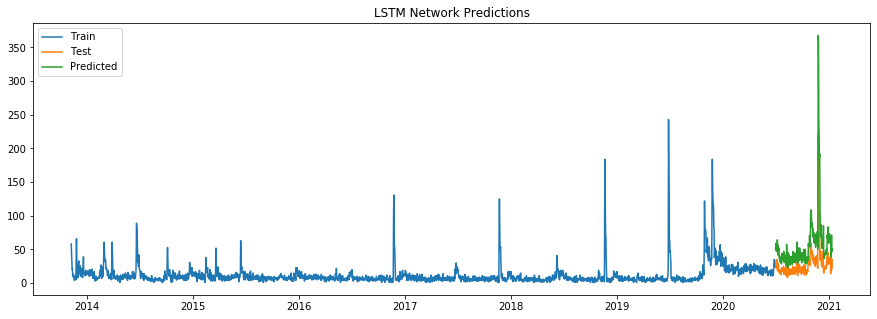

In [72]:
plt.figure(figsize=(15,5))
plt.plot(reviewcount.index[0:-196], raw_values[0:-196], label='Train')
plt.plot(reviewcount.index[-196:], raw_values[-196:], label='Test')
plt.plot(reviewcount.index[-196:], predictions, label='Predicted')
plt.legend(loc='best')
plt.title('LSTM Network Predictions')
plt.show()

In [73]:
starttime = datetime.now()

#######

lstm_modelf = fit_lstm(trainf_scaled, 1, 3000, 4)
# forecast the entire training dataset to build up state for forecasting
trainf_reshaped = trainf_scaled[:, 0].reshape(len(trainf_scaled), 1, 1)
lstm_modelf.predict(trainf_reshaped, batch_size=1)

#######

print(datetime.now() - starttime)

1:00:21.807668


In [74]:
raw_valuesf = reviewcount['dailycountfilter'].values

# walk-forward validation on the test data
predictionsf = list()
for i in range(len(testf_scaled)):
    # make one-step forecast
    Xf, yf = testf_scaled[i, 0:-1], testf_scaled[i, -1]
    yhatf = forecast_lstm(lstm_modelf, 1, Xf)
    # invert scaling
    yhatf = invert_scale(scalerf, X, yhatf)
    # invert differencing
    yhatf = inverse_difference(raw_valuesf, yhatf, len(testf_scaled)+1-i)
    # store forecast
    predictionsf.append(yhatf)
    expectedf = raw_valuesf[len(train) + i + 1]
    print('Day=%d, Predicted=%f, Expected=%f' % (i+1, yhatf, expectedf))

Day=1, Predicted=48.981301, Expected=26.000000
Day=2, Predicted=57.659904, Expected=22.000000
Day=3, Predicted=51.153802, Expected=24.000000
Day=4, Predicted=44.398171, Expected=26.000000
Day=5, Predicted=46.150967, Expected=35.000000
Day=6, Predicted=49.029104, Expected=24.000000
Day=7, Predicted=62.635917, Expected=18.000000
Day=8, Predicted=48.805315, Expected=30.000000
Day=9, Predicted=38.347082, Expected=23.000000
Day=10, Predicted=54.169700, Expected=27.000000
Day=11, Predicted=45.570291, Expected=20.000000
Day=12, Predicted=50.678518, Expected=16.000000
Day=13, Predicted=40.868478, Expected=19.000000
Day=14, Predicted=33.951650, Expected=20.000000
Day=15, Predicted=37.128939, Expected=14.000000
Day=16, Predicted=38.630897, Expected=19.000000
Day=17, Predicted=30.342346, Expected=17.000000
Day=18, Predicted=36.502423, Expected=19.000000
Day=19, Predicted=34.100623, Expected=13.000000
Day=20, Predicted=36.782347, Expected=16.000000
Day=21, Predicted=28.635143, Expected=23.000000
D

Day=178, Predicted=48.145245, Expected=35.000000
Day=179, Predicted=68.158779, Expected=35.000000
Day=180, Predicted=65.877989, Expected=46.000000
Day=181, Predicted=66.366458, Expected=40.000000
Day=182, Predicted=77.802989, Expected=28.000000
Day=183, Predicted=74.265784, Expected=39.000000
Day=184, Predicted=57.925575, Expected=35.000000
Day=185, Predicted=70.830086, Expected=38.000000
Day=186, Predicted=67.291784, Expected=36.000000
Day=187, Predicted=70.741668, Expected=33.000000
Day=188, Predicted=68.966243, Expected=29.000000
Day=189, Predicted=64.680542, Expected=34.000000
Day=190, Predicted=58.189355, Expected=14.000000
Day=191, Predicted=63.987667, Expected=29.000000
Day=192, Predicted=34.955250, Expected=39.000000
Day=193, Predicted=52.915268, Expected=20.000000
Day=194, Predicted=68.482157, Expected=25.000000
Day=195, Predicted=44.026222, Expected=35.000000


IndexError: index 2615 is out of bounds for axis 0 with size 2615

In [75]:
print(r2_score(y_true=raw_valuesf[-196:],
               y_pred=predictionsf))

print(mean_squared_error(y_true=raw_valuesf[-196:],
                         y_pred=predictionsf))

print(mean_absolute_error(y_true=raw_valuesf[-196:],
                         y_pred=predictionsf))

print(mean_absolute_percentage_error(y_true=raw_valuesf[-196:],
                         y_pred=predictionsf))

print(sqrt(mean_squared_error(raw_valuesf[-196:], predictionsf)))

-4.9857413899727145
642.3641548642012
22.888852630722887
102.47012686855392
25.344903922962523


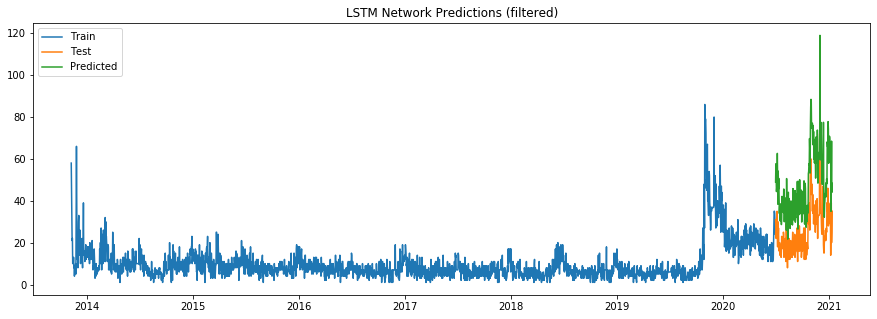

In [76]:
plt.figure(figsize=(15,5))
plt.plot(reviewcount.index[0:-196], raw_valuesf[0:-196], label='Train')
plt.plot(reviewcount.index[-196:], raw_valuesf[-196:], label='Test')
plt.plot(reviewcount.index[-196:], predictionsf, label='Predicted')
plt.legend(loc='best')
plt.title('LSTM Network Predictions (filtered)')
plt.show()

-----

# Summary of the Models

## Non-Filtered Data

### Naive Forecast: 
- R2: -0.04364652356950027
- MSE: 564.1122448979592
- MAE: 11.122448979591837
- MAPE: 34.24892097861555
- RMSE: 23.751047237921092

### Prophet:
- R2: 0.24708421512042555
- MSE: 406.96634735567284
- MAE: 11.534701969750031
- MAPE: 44.53169378768569
- RMSE: 20.173406934766195

### XGBoost:
- R2: 0.6235531409606847
- MSE: 203.47720989970986
- MAE: 8.818258334179314
- MAPE: 30.725074742851348
- RMSE: 14.26454380271973

### Pmdarima:
- R2: -0.2458540094233741
- MSE: 673.4095176853627
- MAE: 19.712605874728695
- MAPE: 84.04734843302037
- RMSE: 25.95013521516531

### LSTM Network:
- R2: -1.617519874541979
- MSE: 1414.8229109628894
- MAE: 28.559460320871096
- MAPE: 109.85023899509261
- RMSE: 37.61413179860582


## Filtered Data

### Naive Forecast: 
- R2: -0.022196028116201916
- MSE: 109.69770408163265
- MAE: 7.85969387755102
- MAPE: 32.581425187657466
- RMSE: 10.473667174472972

### Prophet:
- R2: -0.13874712272895096
- MSE: 122.20546886994023
- MAE: 9.361287241080731
- MAPE: 44.41705405936208
- RMSE: 11.054658243018652


### XGBoost:
- R2: -1.0723830278131445
- MSE: 222.39927946873314
- MAE: 9.268972445507439
- MAPE: 35.46063322499003
- RMSE: 14.913057348133988

### Pmdarima:
- R2: 0.06979314156227223
- MSE: 502.79579079902936
- MAE: 12.167955694244535
- MAPE: 47.560921617702824
- RMSE: 22.42310841072284

### LSTM Network:
- R2: -4.9857413899727145
- MSE: 642.3641548642012
- MAE: 22.888852630722887
- MAPE: 102.47012686855392
- RMSE: 25.344903922962523

----

## Conclusion

Interestingly, after applying the Hampel Filter, all the models lost to the naive forecast in most of the evaluation metrics.

Regardless, it was a test to see if it would be suitable for forecast modeling and it doesn't seem to produce many meaningful results

With the original results, I will be looking at RMSE. RMSE is more sensitive to large errors than other evaluation metrics. MAE is not good here, as the average number of reviews per day is relatively low, thus the mean absolute error relative to the average review is relatively large, thus indicating poor accuracy.

XGBoost in this case gave the best results.